In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

from transformers import CLIPProcessor, CLIPModel

import os
import json
import random
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from PIL import Image
from typing import Dict, List, Tuple, Optional
from collections import defaultdict

# 基本参数
MODEL_NAME = "openai/clip-vit-base-patch32"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 8
EPOCHS = 5
LR = 1e-5
WEIGHT_DECAY = 0.01


# 模型加载与解冻
def prepare_model(model_name=MODEL_NAME, device=DEVICE):
    model = CLIPModel.from_pretrained(model_name).to(device)
    for param in model.parameters():
        param.requires_grad = False
    for name, param in model.vision_model.named_parameters():
        if 'encoder.layers.11' in name or 'post_layernorm' in name:
            param.requires_grad = True
    return model

model = prepare_model()
model.logit_scale.requires_grad_(True)
processor = CLIPProcessor.from_pretrained(MODEL_NAME)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


### load dataset

In [2]:
class RoadSignDataset(Dataset):
    def __init__(self, image_dir, gt_json, label2id=None):
        with open(gt_json, 'r', encoding='utf-8') as f:
            gt = json.load(f)
        labels = sorted(set(gt.values()))
        if label2id is None:
            self.label2id = {label: idx for idx, label in enumerate(labels)}
        else:
            self.label2id = label2id
        self.samples = []
        for fname, label in gt.items():
            path = os.path.join(image_dir, fname)
            self.samples.append((path, self.label2id[label]))
        self.id2label = {v: k for k, v in self.label2id.items()}
    def __len__(self):
        return len(self.samples)
    def __getitem__(self, idx):
        img_path, label_id = self.samples[idx]
        img = Image.open(img_path).convert("RGB")
        return img, label_id

def collate_fn(batch):
    images, labels = zip(*batch)
    return list(images), torch.tensor(labels)

domain = 'cn'   # 可选: 'cn', 'de', 'in'
set_type = 'mx' # 可选: 'mx', 'ai'
SAVE_PATH = f"clip_finetune_{set_type}_{domain}.pth"

train_dir = f"train_{set_type}_{domain}"
train_gt  = f"gt_{set_type}_{domain}.json"
test_dir  = f"test_{domain}"
test_gt   = f"test_{domain}.json"

train_dataset = RoadSignDataset(train_dir, train_gt)
label2id = train_dataset.label2id
id2label = train_dataset.id2label
test_dataset = RoadSignDataset(test_dir, test_gt, label2id=label2id)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
test_loader  = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)


### load prompts

In [3]:
with open(f"prompt_{domain}.json", "r", encoding="utf-8") as f:
    prompts = json.load(f)

prompt_variations = {
    domain: [prompts[id2label[i]] for i in range(len(label2id))]
}

### track training

In [4]:
class TrainingTracker:
    def __init__(self):
        self.train_loss = []
        self.train_acc = []
        self.test_loss = []
        self.test_acc = []

    def record(self, train_loss, train_acc, test_loss, test_acc):
        self.train_loss.append(train_loss)
        self.train_acc.append(train_acc)
        self.test_loss.append(test_loss)
        self.test_acc.append(test_acc)

    def plot(self):
        fig, ax1 = plt.subplots(figsize=(8, 5))
        ax1.plot(self.train_loss, label='Train Loss', color='tab:blue', linestyle='-')
        ax1.plot(self.test_loss,  label='Test Loss',  color='tab:blue', linestyle='--')
        ax1.set_xlabel("Epoch")
        ax1.set_ylabel("Loss", color='tab:blue')
        ax1.tick_params(axis='y', labelcolor='tab:blue')
        ax2 = ax1.twinx()
        ax2.plot(self.train_acc, label='Train Acc', color='tab:orange', linestyle='-')
        ax2.plot(self.test_acc,  label='Test Acc',  color='tab:orange', linestyle='--')
        ax2.set_ylabel("Accuracy", color='tab:orange')
        ax2.tick_params(axis='y', labelcolor='tab:orange')
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, loc='center right')
        plt.title("Training History")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    def to_dataframe(self):
        data = {
            'Train Loss': self.train_loss,
            'Train Acc': self.train_acc,
            'Test Loss': self.test_loss,
            'Test Acc': self.test_acc
        }
        return pd.DataFrame(data)



### loss, features, evaluation function

In [5]:
def clip_prompt_classification_loss(
    image_features: torch.Tensor,
    text_features: torch.Tensor,
    target_indices: torch.Tensor
) -> torch.Tensor:
    # 归一化向量
    image_features = nn.functional.normalize(image_features, dim=-1)
    text_features = nn.functional.normalize(text_features, dim=-1)

    # 相似度得分
    logits = image_features @ text_features.T

    # 分类损失
    return nn.CrossEntropyLoss()(logits, target_indices)

def get_all_prompt_text_features(model, processor, prompt_variations, categories, domain, device):
    all_prompts = []
    prompt_to_cat = []
    for i in range(len(categories)):
        these_prompts = prompt_variations[domain][i]
        all_prompts.extend(these_prompts)
        prompt_to_cat.extend([i] * len(these_prompts))
    text_inputs = processor(text=all_prompts, return_tensors="pt", padding=True, truncation=True).to(device)
    with torch.no_grad():
        feats = model.get_text_features(**text_inputs)
        feats = nn.functional.normalize(feats, dim=-1)
    return feats, prompt_to_cat

def get_class_text_features_avg(model, processor, prompt_variations, categories, domain, device):
    """
    每类所有 prompt embedding 平均化，得到类别 embedding。只用单一 domain。
    prompt_variations[domain] 是一个 list，顺序和 categories（或 label2id 顺序）一致。
    """
    all_prompts = []
    prompt_to_cat = []
    for i in range(len(categories)):
        these_prompts = prompt_variations[domain][i]  # 本类别的所有prompts
        all_prompts.extend(these_prompts)
        prompt_to_cat.extend([i] * len(these_prompts))
    text_inputs = processor(text=all_prompts, return_tensors="pt", padding=True, truncation=True).to(device)
    with torch.no_grad():
        feats = model.get_text_features(**text_inputs)
        feats = nn.functional.normalize(feats, dim=-1)
    # 平均
    C = len(categories)
    class_feats = torch.zeros(C, feats.shape[1], device=feats.device)
    counts = torch.zeros(C, device=feats.device)
    for i, cat_id in enumerate(prompt_to_cat):
        class_feats[cat_id] += feats[i]
        counts[cat_id] += 1
    class_feats = class_feats / counts.unsqueeze(1)
    class_feats = nn.functional.normalize(class_feats, dim=-1)
    return class_feats

def evaluate(model, dataloader, processor, prompt_variations, categories, domain, device):
    model.eval()
    class_text_features = get_class_text_features_avg(
        model, processor, prompt_variations, categories, domain, device
    )
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, category_indices in dataloader:
            image_inputs = processor(images=list(images), return_tensors="pt").to(device)
            category_indices = category_indices.to(device)
            image_features = model.get_image_features(**image_inputs)
            loss = clip_prompt_classification_loss(image_features, class_text_features, category_indices)
            total_loss += loss.item()
            logits = image_features @ class_text_features.T
            preds = logits.argmax(dim=1)
            correct += (preds == category_indices).sum().item()
            total += len(images)
    avg_loss = total_loss / len(dataloader)
    acc = correct / total
    return avg_loss, acc


In [6]:
def train_model(
    model, train_loader, processor, prompt_variations, categories, domain,  # domain是字符串，如'cn'
    test_loader=None, epochs=EPOCHS, save_path=SAVE_PATH, device=DEVICE
):
    tracker = TrainingTracker()
    optimizer = torch.optim.AdamW(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=LR, weight_decay=WEIGHT_DECAY
    )

    # 新增：一次性获取所有 prompt embedding 和 prompt_to_cat
    all_prompt_feats, prompt_to_cat = get_all_prompt_text_features(
        model, processor, prompt_variations, categories, domain, device
    )

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        train_correct, train_total = 0, 0

        # 每轮重算一次类别embedding（平均所有prompt）
        class_text_features = get_class_text_features_avg(
            model, processor, prompt_variations, categories, domain, device
        )

        for images, category_indices in train_loader:
            image_inputs = processor(images=list(images), return_tensors="pt").to(device)
            category_indices = category_indices.to(device)

            image_features = model.get_image_features(**image_inputs)
            loss = clip_prompt_classification_loss(image_features, class_text_features, category_indices)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            with torch.no_grad():
                logits = image_features @ all_prompt_feats.T   # [B, N_prompt]
                # 按 prompt_to_cat 聚合到类别
                num_categories = len(categories)
                logits_by_cat = torch.zeros(logits.size(0), num_categories, device=logits.device)
                for i in range(num_categories):
                    idxs = [j for j, c in enumerate(prompt_to_cat) if c == i]
                    if len(idxs) == 0:
                        continue
                    logits_by_cat[:, i] = logits[:, idxs].mean(dim=1)
                preds = logits_by_cat.argmax(dim=1)
                train_correct += (preds == category_indices).sum().item()
                train_total += len(images)

        avg_train_loss = total_loss / len(train_loader)
        train_acc = train_correct / train_total

        # ========== 测试（Test集） ========== #
        if test_loader is not None:
            test_loss, test_acc = evaluate(
                model, test_loader, processor, prompt_variations, categories, domain, device
            )
        else:
            test_loss, test_acc = None, None

        tracker.record(avg_train_loss, train_acc, test_loss, test_acc)
        print(f"[Epoch {epoch+1}/{epochs}] "
              f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.2%} | "
              f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2%}")

    torch.save({
        'model_state_dict': model.state_dict(),
        'categories': categories,
    }, save_path)

    print(f"Model saved to {save_path}")
    return tracker


### Train with 1 dataset

In [7]:
# categories顺序要与label2id一致
categories = [label for label, _ in sorted(label2id.items(), key=lambda x: x[1])]
history = train_model(
    model, train_loader, processor,
    prompt_variations=prompt_variations,
    categories=categories,
    domain=domain,
    test_loader=test_loader,
    epochs=20
)


[Epoch 1/20] Train Loss: 3.1833 | Train Acc: 52.00% | Test Loss: 3.1803 | Test Acc: 45.83%
[Epoch 2/20] Train Loss: 3.1701 | Train Acc: 62.40% | Test Loss: 3.1695 | Test Acc: 51.67%
[Epoch 3/20] Train Loss: 3.1554 | Train Acc: 73.60% | Test Loss: 3.1569 | Test Acc: 55.00%
[Epoch 4/20] Train Loss: 3.1401 | Train Acc: 79.20% | Test Loss: 3.1435 | Test Acc: 58.33%
[Epoch 5/20] Train Loss: 3.1253 | Train Acc: 81.60% | Test Loss: 3.1307 | Test Acc: 60.83%
[Epoch 6/20] Train Loss: 3.1107 | Train Acc: 82.40% | Test Loss: 3.1188 | Test Acc: 57.50%
[Epoch 7/20] Train Loss: 3.0972 | Train Acc: 81.60% | Test Loss: 3.1075 | Test Acc: 58.75%
[Epoch 8/20] Train Loss: 3.0846 | Train Acc: 81.60% | Test Loss: 3.0975 | Test Acc: 58.33%
[Epoch 9/20] Train Loss: 3.0733 | Train Acc: 82.40% | Test Loss: 3.0880 | Test Acc: 59.58%
[Epoch 10/20] Train Loss: 3.0635 | Train Acc: 83.20% | Test Loss: 3.0798 | Test Acc: 60.00%
[Epoch 11/20] Train Loss: 3.0545 | Train Acc: 83.20% | Test Loss: 3.0726 | Test Acc: 59.1

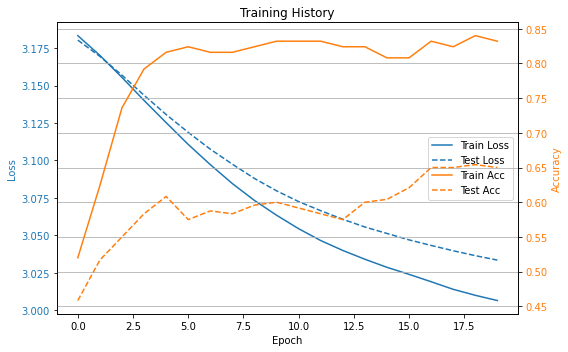

In [8]:
history.plot()